In [1]:
#instal·lació de llibreries.
import warnings
warnings.filterwarnings('ignore')
!pip install gym==0.25.0
#!pip install autorom[accept-rom-license]
#!pip install imageio
!pip install gym[box2d]
!pip install matplotlib
#!pip install scikit-image
!pip install torch
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque
import random
import torch.nn.functional as F
from torch.distributions import Categorical
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.4/720.4 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.25.0-py3-none-any.whl size=824415 sha256=99cece97a0652010b351745d0521da85c713f1383000958a38397efd2c893d40
  Stored in directory: /root/.cache/pip/wheels/2c/58/d8/1590abcfe48cdf414681b1e2b6647045b85f7c924563b664ee
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.9 MB/s eta 0:00:00


In [2]:
# Convert frame to image
def _toImage(frame):
    # Convert the frame data to a numpy array and create an image object using PIL
    im = Image.fromarray(np.uint8(frame[0]))
    # resize the image by a factor of 2 in both dimensions
    im = im.resize((im.size[0]*2,im.size[1]*2))
    # return the resized image
    return im

# Save a random agent
def save_random_agent_gif(env):
    # Create an empty list to hold the frames
    frames = []
    # Set the done flag to False to start the loop
    done = False
    # Reset the environment
    env.reset()
    
    # Keep taking random actions and rendering the environment until the episode is over
    while not done:
        # Choose a random action from the action space
        action = env.action_space.sample()
        # Render the environment to an image and store the result in the frame variable
        frame = env.render(mode='rgb_array')
        # Convert the frame to an image object and append it to the list of frames
        frames.append(_toImage(frame))
        # Step the environment and get the new state, reward, done flag, and info
        state, _, done, _ = env.step(action)

    # Close the environment
    env.close()
    # Use the imageio library to save the list of frames as an animated gif
    imageio.mimwrite(os.path.join('./videos/', 'random_agent_lunar_landing.gif'), frames, fps=60)

# Save an example as gif
def save_agent_gif(env, ag, nombre_fichero):
    # Create an empty list to hold the frames
    frames = []
    # Reset the environment
    state = env.reset()
    # Set the done flag to False and total_reward to 0 to start the loop
    done = False
    total_reward = 0
    
    # play once Lunar Lander and render the environment
    while not done:
            frame = env.render(mode='rgb_array')
            frames.append(_toImage(frame))
            action = ag.main_network.get_action(state,epsilon=0.0)
            state, _, done, _ = env.step(action)
            if done:
                break
    # Close the environment
    env.close()
    # Use the imageio library to save the list of frames as an animated gif
    imageio.mimwrite(os.path.join('./videos/', nombre_fichero), frames, fps=60)

In [9]:
# Create a LunarLander-v2 environment and set the rendering mode to 'rgb_array'
env = gym.make('LunarLander-v2', render_mode='rgb_array')
# Set the random seed for reproducibility
env.seed(0)
# Print the shape of the observation space and the number of actions
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)
# try to create a folder videos, if the folder already exists it will be ignore
try:
    os.makedirs('videos')
except:
    pass
# save the random agent gif
save_random_agent_gif(env)

State shape:  (8,)
Number of actions:  4


In [4]:
class DQN(torch.nn.Module):
    """
    Implementation of a DQN (Deep Q-Network) model. 
    Attributes:
    
        -env: is the OpenAI gym environment
        -seed: is a random seed used for reproducibility
        -learning_rate: is the Adam optimizer learning rate
        -red_princ: main network
        -optimizer: is the optimizer used to update the model parameters
        -device: is the device used to run the model, it's 'cpu'
    
    Methods:
        - __init__(self, env, seed, learning_rate=1e-3) : constructor of the class
        - get_action(self, state, epsilon=0.05) : It takes action for the current 
            state using epsilon-greedy policy, it choose a random action with 
            probability epsilon or it uses the action that have the highest Q-value.
        - get_qvals(self, state) : it returns the q-values of the state, it 
            converts the state to a torch tensor and then passes it through the network
        - forward(self, x) : It's the forward pass of the neural network, it pass 
            the input x through the network, which is stored in self.red_princ, 
            and returns the output.
    """    
    # initialization
    def __init__(self, env, seed, learning_rate=1e-3):
        super(DQN, self).__init__()
        self.state_shape = env.observation_space.shape
        self.state_size = self.state_shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.actions_size = len(self.actions)
        self.seed = torch.manual_seed(seed)
        self.device = 'cpu'
        
        self.red_princ = nn.Sequential(
            nn.Linear(self.state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.actions_size)  # Neural netowrk for action-value function.
            )
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)


    def get_action(self, state, epsilon=0.05):
        """
        Take action for the current state using epsilon-greedy policy.
        """
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions) 
        else:
            qvals = self.get_qvals(state)
            action= torch.max(qvals, dim=-1)[1].item()
        return action

    def get_qvals(self, state):
        """
        Get action-values for the current state.
        """
        if type(state) is tuple:
            state = np.array(state)
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.forward(state_t)

    def forward(self, x):
        """
        Forward pass of the network.
        """
        x = self.red_princ(x)
        return x

In [6]:
class experienceReplayBuffer:
    """
    Implementation of aexperience buffer.
    Attributes:
    - memory_size: the size of the buffer's memory
    - seed: seed for reproducibility
    - burn_in: the number of experiences initially in the buffer

    Methods:
    - __init__(self, seed, memory_size=50000, burn_in=10000): This is the constructor 
    method of the class,
    - sample_batch(self, batch_size=32): This method returns a batch of 
    samples from the buffer
    - append(self, state, action, reward, done, next_state): This method 
    adds an experience into the buffer.
    - size(self): This method returns the size of the buffer.
    - burn_in_capacity(self): This method returns the burn in capacity of
    the buffer.
    """
    def __init__(self, seed, memory_size=50000, burn_in=10000):
        #maximum number of experiences to store in the deque
        self.memory_size = memory_size 
        #number of experiences needed to be stored before using sample_batch
        self.burn_in = burn_in 
        #Structure to store the experience tuple
        self.buffer = namedtuple('Buffer',
            field_names=['state', 'action', 'reward', 'done', 'next_state']) 
        #deque to store the experiences
        self.replay_memory = deque(maxlen=memory_size) 
        self.seed = random.seed(seed)

    def sample_batch(self, batch_size=32):
        # check if replay memory has enough experiences
        if len(self.replay_memory) < batch_size:  
            # return empty batches if not
            return [], [], [], [], []  
        samples = np.random.choice(len(self.replay_memory), batch_size, replace=False)
        # Use the * operator to unpack deque
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch
    
    # append an experience into the buffer
    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))
    
    # return the size of the buffer
    def size(self):
        return len(self.replay_memory)
    
    # return the burn in capacity of the buffer
    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in # return the burn in capacity

In [11]:
class Agent:
    """
    Implementation of a reinforcement learning Agent.
    Attributes:
    - env: gym environment
    - seed: seed for reproducibility
    - device: the type of the the device cpu/cuda
    - main_network: The neural network
    - target_network: The target neural network
    - buffer: The replay buffer
    - update_loss: the list of losses in every step in an episode
    - training_rewards: the list of rewards during training
    - mean_training_rewards: the list of last 100 iterations mean rewards
    - loss_history: the list of the last loss of every iteration
    - epsilon_history: the list of the epsilon values during training
    - sync_eps: list of episodes for the network syncronization
    - epsilon: epsilon value
    - total_reward: the total reward of an episode
    - step_count: iteration counter
    - state0: initial state of the episode
    - reward_threshold: the reward threshold to consider that the agent has
        solved the environment
    - episode: the episode number

    Methods:
    - __init__(self, env, main_network, target_network, buffer, seed): This 
        is the constructor method of the class,
    - initialize(self): This method initializes the variables
    - take_step(self, eps, mode='train'): In this method the agent takes a step,
        wether exploring or according the policy, saves the current state into
        the buffer and returns if the episode is done or not.
    - train(self, gamma=0.99, max_episodes=50000, batch_size=32,
        dnn_update_frequency=4, dnn_sync_frequency=2000, min_episodis=250, 
        min_epsilon = 0.01, eps_decay=0.99, nblock=100): This method is the
        training method for the agent.
    - calculate_loss(self, batch): This method calculates the loss.
    - update(self): this method updates the network
    - plot_rewards(self): this method plots the mean rewards
    
    """
    def __init__(self, env, main_network, target_network, buffer, seed):
        """
        Initialize the agent
        :param env: The gym environment 
        :param main_network: The neural network 
        :param target_network: The target neural network 
        :param buffer: The replay buffer 
        :param seed: random seed
        """
        self.device = 'cpu'
        self.env = env
        self.main_network = main_network
        self.target_network = target_network
        self.buffer = buffer
        self.seed = random.seed(seed)
        self.initialize()

    def initialize(self):
        """
        Initialize the variables
        """
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.loss_history = []
        self.epsilon_history = []
        self.sync_eps = []
        self.epsilon = 1
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
        self.reward_threshold = 500
        self.episode = 0

    def take_step(self, eps, mode='train'):
        """
        The agent will take a step and the current state, action,reward,done and the next state 
        are stored in the replay buffer
        :param eps: The epsilon for the epsilon-greedy policy
        :param mode:  'explore' for random action, 'train' for training
        :return: done,  if done is True the episode is finished
        """
        if mode == 'explore':
            action = self.env.action_space.sample()
        else:
            action = self.main_network.get_action(self.state0, eps)
            self.step_count += 1

        new_state, reward, done, _ = env.step(action)   
        
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()

        if done:
            self.state0 = self.env.reset()
        return done

    def train(self, gamma=0.99, max_episodes=50000, batch_size=32, 
              dnn_update_frequency=4, dnn_sync_frequency=2000, 
              min_episodis=250, min_epsilon = 0.01,
              eps_decay=0.99, nblock=100):
        """
        The main training loop
        :param gamma: The discount factor 
        :param max_episodes: The maximum number of episodes to train
        :param batch_size: The batch size for the experience replay
        :param dnn_update_frequency: How often the network is updated
        :param dnn_sync_frequency: How often the target network is synced
        :param min_episodis: Minimum number of episodes before consider the problem solved
        :param min_epsilon: Minimum epsilon for the epsilon-greedy policy
        :param eps_decay: The decay rate for the epsilon-greedy policy
        :param nblock: The number of episodes to calculate the mean rewards for
        """
        self.gamma = gamma
        self.batch_size = batch_size
            
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        self.episode = 0
        training = True
        print("Training...")
        maximo = -1000
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            done = False
            moves = 0
            while done == False:
                done = self.take_step(self.epsilon, mode='train')
                moves += 1
                """
                update and sync the networks
                """
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    self.sync_eps.append(self.episode)
                """
                update the episode, rewards and epsilon
                """
                if done:
                    self.episode += 1
                    self.epsilon_history.append(self.epsilon)
                    self.training_rewards.append(self.total_reward)
                    if self.update_loss != []:
                        self.loss_history.append(self.update_loss[-1])
                    self.update_loss = []

                    mean_rewards = np.mean(self.training_rewards[-nblock:])
                    self.mean_training_rewards.append(mean_rewards)
                    maximo = max(maximo,mean_rewards)
                    """
                    Display the progress
                    """
                    print("\rEpisode {:d} Mean Rewards {:.2f} Last reward {} , Maxim {:.2f}\t\t".format(
                        self.episode, mean_rewards, self.total_reward, maximo), end="")

                    if self.episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached.')
                        break

                    if mean_rewards >= self.reward_threshold and min_episodis<self.episode:
                        training = False
                        print('\nEnvironment solved in {} episodes!'.format(
                            self.episode))
                        break
                    
                    """
                    decrease epsilon
                    """
                    if self.epsilon > min_epsilon:
                        self.epsilon *= eps_decay


    def calculate_loss(self, batch):
        """
        Calculate the loss
        :param samples: a batch of samples from the replay buffer
        :return: the calculated loss
        """
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_vals = torch.FloatTensor(rewards).to(device=self.device).reshape(-1,1)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1).to(
            device=self.device)
        dones_t = torch.ByteTensor(dones).to(device=self.device)

        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)

        next_actions = torch.max(self.main_network.get_qvals(next_states), dim=-1)[1]
        next_actions_vals = torch.LongTensor(next_actions).reshape(-1,1).to(device=self.device)
        target_qvals = self.target_network.get_qvals(next_states)
        qvals_next = torch.gather(target_qvals, 1, next_actions_vals).detach()

        qvals_next[dones_t] = 0

        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
      
        return loss

    def update(self):
        """
        Update the network
        """
        self.main_network.optimizer.zero_grad()
        batch = self.buffer.sample_batch(self.batch_size) 
        loss = self.calculate_loss(batch) 
        loss.backward()
        self.main_network.optimizer.step() 
        self.update_loss.append(loss.detach().numpy())


    def plot_rewards(self):
        """
        Plot the rewards
        """
        plt.figure(figsize=(12,8))
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(200, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.show()
        

In [8]:
# Parameters

lr = 0.0005             # learning rate
BATCH_SIZE = 128        # size of the buffer
MEMORY_SIZE = 10000     # maximum buffer size
GAMMA = 0.99            # Bellman's equation gamma
MAX_EPISODES = 2000     # Maximum number of iterations
MIN_EPISODES = 100      # Minimum number of iterations
EPSILON = 1             # Initial epsilon value
EPSILON_DECAY = .995    # epsilon decay
EPSILON_MIN = 0.01      # Minimum epsilon
BURN_IN = 128           # Number of episodes to fill initially the buffer
DNN_UPD = 5             # Network Update frequency
DNN_SYNC = 5            # Network syncronization update (between main and target)
NBLOCK = 100            # number of iterations to get the mean
REWARD_THRESHOLD = 500  # reward to consider the environment solved (will never be reached)
MAX_STEPS = 10000       # maximum steps per episode

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Training the DQN model
resultsDQN = []
i = 0

DNN_UPD = DNN_SYNC
                
# Create experience replay buffer
buffer = experienceReplayBuffer(seed=0, memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# Create main and target networks
dqn_main = DQN(env, seed=0, learning_rate=lr)
dqn_target = DQN(env, seed=0, learning_rate=lr)

# Create the agent
DQNAgent = Agent(env, main_network=dqn_main, target_network=dqn_target,
                 buffer=buffer, seed=0)

# train the agent
DQNAgent.train(gamma=GAMMA, max_episodes=MAX_EPISODES,batch_size=BATCH_SIZE,
               dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC, 
               min_episodis=MIN_EPISODES, min_epsilon=EPSILON_MIN,
               eps_decay=EPSILON_DECAY,nblock=NBLOCK)
                               
# play once and save the gif
name = 'agent_dqn_lunarLanding_'+str(i)+'.gif'
save_agent_gif(env,DQNAgent, name)

# get main results into resultsDQN variable
resultsDQN = DQNAgent.mean_training_rewards
                
# save model
name="/kaggle/working/DQN_"+str(i)+".pth"
torch.save(dqn_main.state_dict(), name)

# Save results to file
output_file = open('resultsDQN.txt', 'w')
output_file.write(str(resultsDQN))
output_file.close()  

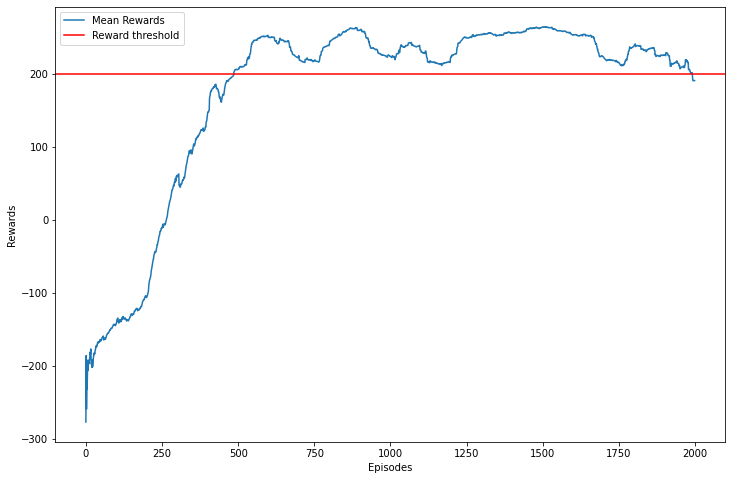

In [13]:
# print metrics
DQNAgent.plot_rewards()

In [ ]:
class duelingDQN(torch.nn.Module):
    """
    Implementation of a dueing DQN (Deep Q-Network) model.
    Attributes:
    - env: gym environment
    - seed: seed for reproducibility
    - learning_rate: learning rate used by the Adam optimizer
    - state_shape: shape of the observation space of the environment
    - state_size: the first element of the state_shape tuple.
    - n_outputs: the number of actions in the environment
    - actions: array that holds all the actions possible for the environment
    - actions_size: the length of the actions array.
    - red_princ: the neural network of the agent
    - advantage: a linear layer that calculate the advantage of the features
    - value: a linear layer that calculate the value of the features
    - optimizer: the optimizer used to update the parameters of the network

    Methods:
    - __init__(self, env, seed, learning_rate=1e-3): This is the constructor 
    method of the class,
    - forward(self, state_t): This method is used to propagate the input state 
        through the network and obtain the Q-values. It takes in the state as 
        an input, it extracts the features, it calculates the values and advantages, 
        then it calculates the qvals as values + (advantages - advantages.mean())
    - get_action(self, state, epsilon=0.05): This method determines the action 
        that the agent should take given the current state. It returns the action 
        that maximizes the Q-value of the input state, or select a random action 
        with probability epsilon.
    - get_qvals(self, state): This method convert the input state to a torch 
        tensor and sends it to the device and it returns the output of the forward method.
    - parameters(): This is a Pytorch method that returns an iterator over the 
        model parameters.
    """
    def __init__(self, env, seed, learning_rate=1e-3):
        # Initialize the parent class and set the seed for reproducibility
        super(duelingDQN, self).__init__()
        self.state_shape = env.observation_space.shape
        self.state_size = self.state_shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.actions_size = len(self.actions)
        self.seed = torch.manual_seed(seed)
        self.device = 'cpu'
        
        # The principal network is composed by sequential layers, which are linear layers, ReLU activation function, linear layers and ReLU activation function, and a final linear layer.
        self.red_princ = nn.Sequential(
            nn.Linear(self.state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.actions_size)
            )
        
        # the two separate layers of the dueling architecture, one for advantage and the other for value.
        self.advantage = nn.Linear(self.actions_size,self.n_outputs)
        self.value = nn.Linear(self.actions_size,1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    
    def forward(self, state_t):
        # Extract the features of the input state
        features = self.red_princ(state_t).reshape(-1,  self.actions_size)
        # calculate the values and advantages
        values = self.value(features)
        advantages = self.advantage(features)
        #calculate the qvals as values + (advantages - advantages.mean())
        qvals = values + (advantages - advantages.mean())
        
        return qvals
    
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            # select a random action with probability epsilon
            action = np.random.choice(self.actions)
        else:
            #  otherwise, choose the action with the highest Q-value
            qvals = self.get_qvals(state)
            action= torch.max(qvals, dim=-1)[1].item()
        return action

    def get_qvals(self, state):
        if type(state) is tuple:
            state = np.array(state)
        # Convert the input state to a torch tensor and send it to the device
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.forward(state_t)

Filling replay buffer...
Training...
Episode 2000 Mean Rewards 114.39 Last reward 255.2995896981729 , Maxim 264.58					
Episode limit reached.


/opt/conda/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


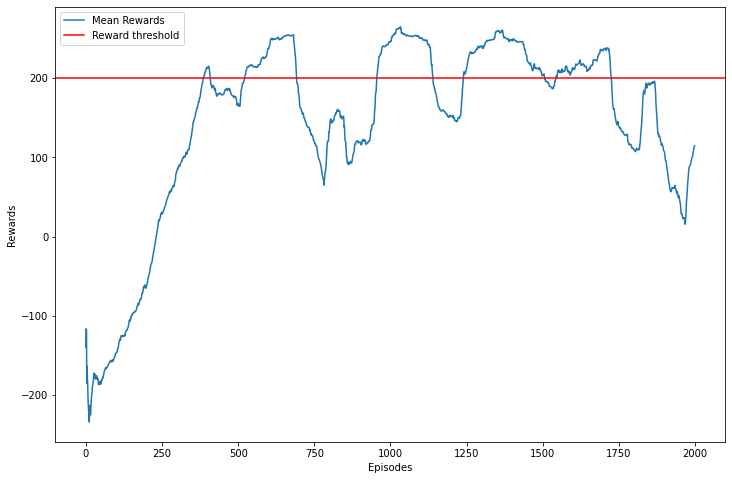

In [14]:
# Training the dueling DQN

resultsDDQN = []
i = 0

DNN_UPD = DNN_SYNC
                
# create experience replay buffer
buffer = experienceReplayBuffer(seed=0, memory_size=MEMORY_SIZE, burn_in=BURN_IN)

# ccreate main and target networks
ddqn_main = duelingDQN(env, seed=0, learning_rate=lr)
ddqn_target = duelingDQN(env, seed=0, learning_rate=lr)
                
# create the agent
DDQNAgent = Agent(env, main_network=ddqn_main, target_network=ddqn_target,
                  buffer=buffer, seed=0)

# train the agent
DDQNAgent.train(gamma=GAMMA, max_episodes=MAX_EPISODES,batch_size=BATCH_SIZE, 
                dnn_update_frequency=DNN_UPD, dnn_sync_frequency=DNN_SYNC, 
                min_episodis=MIN_EPISODES, min_epsilon=EPSILON_MIN,
                eps_decay=EPSILON_DECAY,nblock=NBLOCK)
                     
# try one episode and save the gif
name = 'agent_duelingdqn_lunarLanding_'+str(i)+'.gif'
save_agent_gif(env,DDQNAgent, name)

# save mean revards into resultsDDQN variable
resultsDDQN = DDQNAgent.mean_training_rewards
                
# save model
name="/kaggle/working/DDQN_"+str(i)+".pth"
torch.save(ddqn_main.state_dict(), name)
    
# print rewards
DDQNAgent.plot_rewards()
    
# Save list to file
output_file = open('resultsDueling.txt', 'w')
output_file.write(str(resultsDDQN))
output_file.close()

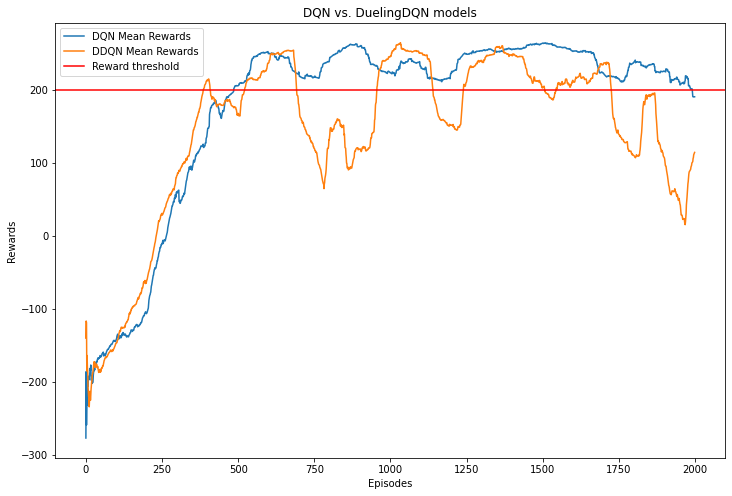

In [19]:
# Plot DQN vs DDQN mean rewards
plt.figure(figsize=(12,8))
plt.plot(DQNAgent.mean_training_rewards, label='DQN Mean Rewards')
plt.plot(DDQNAgent.mean_training_rewards, label='DDQN Mean Rewards')
plt.axhline(200, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('DQN vs. DuelingDQN models')
plt.legend(loc="upper left")
plt.show()

In [16]:
class EWC_DQN(DQN):
    """
    The class EWC_DQN inherits from class DQN.
    
    New methods are:
    - __init__(self, env, seed, learning_rate=1e-3, lamda = 1000): this
        is the constructor of the class
    - compute_fisher(self, replay_memory): calculates the Fisher information
        matrix
    - forward(self, x): redefines the forward function for the output of the network
    """
    def __init__(self, env, seed, learning_rate=1e-3, lamda = 1000):
        super(EWC_DQN, self).__init__(env,seed, learning_rate)
        self.lamda = lamda
        self.params = {}
        for name, p in self.red_princ.named_parameters():
            self.params[name] = p.data.clone()
        self.fisher_n = {}
        for name, p in self.red_princ.named_parameters():
            self.fisher_n[name] = torch.zeros_like(p.data)

    def compute_fisher(self, replay_memory):
        """
        Compute the fisher information matrix
        """
        for name, p in self.red_princ.named_parameters():
            self.fisher_n[name].data.zero_()

        for state, action, reward, done, next_state in replay_memory:
            q_vals = self.main_network.get_qvals(state)
            q_val = q_vals[action]
            q_val.backward()
            for name, p in self.red_princ.named_parameters():
                self.fisher_n[name].data += p.grad.data ** 2 / len(replay_memory)
            self.main_network.zero_grad()
            
    def forward(self, x):
        qvals = self.red_princ(x)
        ewc_loss = 0
        for name, p in self.red_princ.named_parameters():
            ewc_loss += (self.fisher_n[name]*(p-self.params[name])**2).sum()
        self.loss = ewc_loss
        return qvals 

In [17]:
class EWC_agent(Agent):
    """
    The EWC_agent class inherits form the Agent class.
    
    The methods are adapted to the EWC_DQN class.
    """
    def __init__(self, env, main_network, target_network, buffer, seed):

        self.device = 'cpu'
        self.env = env
        self.main_network = main_network
        self.target_network = target_network
        self.buffer = buffer
        self.seed = random.seed(seed)
        self.initialize()

    def initialize(self):

        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.loss_history = []
        self.epsilon_history = []
        self.sync_eps = []
        self.epsilon = 1
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
        self.reward_threshold = 500
        self.episode = 0

    def take_step(self, eps, mode='train'):
        # Select an action based on the current state and exploration probability (eps)
        if mode == 'explore':
            # Take a random action if in exploration mode
            action = self.env.action_space.sample()
        else:
            # Use the main_network to select an action if in train mode
            action = self.main_network.get_action(self.state0, eps)
            self.step_count += 1

        # Take a step in the environment with the selected action
        new_state, reward, done, _ = env.step(action)   

        # Update total reward and append the current experience to the replay buffer
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()

        # Reset the environment if the episode is done
        if done:
            self.state0 = self.env.reset()
        return done

    def train(self, ewc=False, gamma=0.99, max_episodes=50000, batch_size=32, 
                  dnn_update_frequency=4, dnn_sync_frequency=2000, 
                  min_episodis=250, min_epsilon = 0.01,
                  eps_decay=0.99, nblock=100):
        self.gamma = gamma
        self.batch_size = batch_size
        if ewc:
            self.main_network.compute_fisher(self.buffer.replay_memory) # passing the replay memory to the computation of the fisher information matrix
        print("Filling replay buffer...")
        # Take random actions to fill the replay buffer
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

        self.episode = 0
        training = True
        print("Training...")
        maximo=-1000
        # Main training loop
        while training:
            self.state0 = self.env.reset()
            self.total_reward
            self.total_reward = 0
            done = False
            moves = 0
            # Take steps in the environment until the episode is done
            while done == False:
                done = self.take_step(self.epsilon, mode='train')
                moves += 1

                # Update the main network every dnn_update_frequency steps
                if self.step_count % dnn_update_frequency == 0:
                    self.update()

                # Synchronize the target network with the main network every dnn_sync_frequency steps
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict())
                    self.sync_eps.append(self.episode)

            # Decrease the exploration probability over time
            self.epsilon = max(min_epsilon, eps_decay*self.epsilon)

            # Record the episode's total reward
            self.training_rewards.append(self.total_reward)
            mean_rewards = np.mean(self.training_rewards[-nblock:])
            self.mean_training_rewards.append(mean_rewards)

            self.episode += 1
            self.epsilon_history.append(self.epsilon)
            self.sync_eps.append(self.step_count)
            
            """
            Display the progress
            """
            maximo = max(maximo,mean_rewards)
            print("\rEpisode {:d} Mean Rewards {:.2f} Last reward {} , Maxim {:.2f}\t\t".format(
                    self.episode, mean_rewards, self.total_reward, maximo), end="")
            
            # Check if the maximum number of episodes has been reached
            if self.episode >= max_episodes:
                training = False
                print('\nEpisode limit reached.')
                break
            
            # Check if reward threshold has been reached
            if mean_rewards >= self.reward_threshold and min_episodis<self.episode:
                training = False
                print('\nEnvironment solved in {} episodes!'.format(
                            self.episode))
                break



In [18]:
# train EWC model
resultsEWC = []
i = 0
lam=1000
BATCH_SIZE=64

# create experience replay buffer
buffer = experienceReplayBuffer(seed=0, memory_size=MEMORY_SIZE, 
                                burn_in=BURN_IN)

# create main and target networks
dqn_main = EWC_DQN(env, seed=0, learning_rate=lr, lamda=lam)
dqn_target = EWC_DQN(env, seed=0, learning_rate=lr, lamda=lam)

# create agent
EWC_Agent = EWC_agent(env, main_network=dqn_main, target_network=dqn_target,
                      buffer=buffer, seed=0)

# train the agent
EWC_Agent.train(ewc=True,gamma=GAMMA, max_episodes=MAX_EPISODES, 
                batch_size=BATCH_SIZE, dnn_update_frequency=DNN_UPD,
                dnn_sync_frequency=DNN_SYNC, min_episodis=MIN_EPISODES, 
                min_epsilon=EPSILON_MIN,eps_decay=EPSILON_DECAY,nblock=NBLOCK)
                
                    
# run one apisode and save the gif
name = 'agent_ewc_lunarLanding_'+str(i)+'.gif'
save_agent_gif(env,EWC_Agent, name)

# save the mean rewards history in resultsEWC variable
resultsEWC=EWC_Agent.mean_training_rewards

# save model
name="/kaggle/working/EWC_"+str(i)+".pth"
torch.save(dqn_main.state_dict(), name)
                
# Save list to file
output_file = open('resultsEWC.txt', 'w')
output_file.write(str(resultsEWC))
output_file.close()

Filling replay buffer...
Training...
Episode 2000 Mean Rewards 268.47 Last reward 254.18886701303603 , Maxim 276.62				
Episode limit reached.


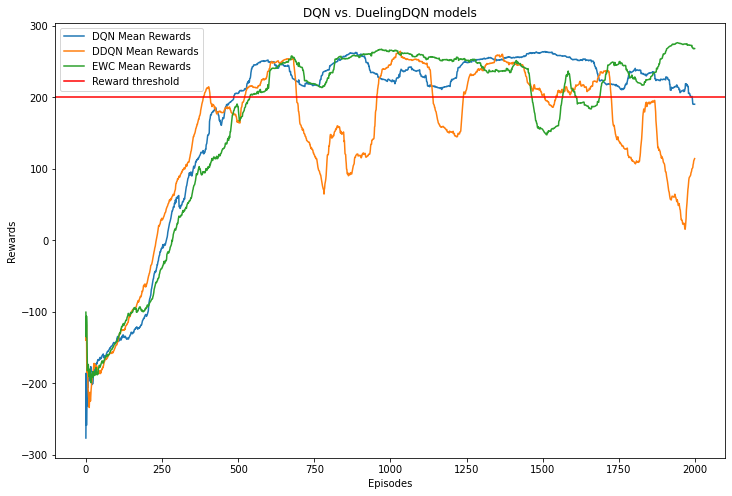

In [20]:
# Plot DQN vs DDQN vs EWC mean rewards
plt.figure(figsize=(12,8))
plt.plot(DQNAgent.mean_training_rewards, label='DQN Mean Rewards')
plt.plot(DDQNAgent.mean_training_rewards, label='DDQN Mean Rewards')
plt.plot(EWC_Agent.mean_training_rewards, label='EWC Mean Rewards')
plt.axhline(200, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('DQN vs. DuelingDQN models')
plt.legend(loc="upper left")
plt.show()

In [21]:
class actorNetwork(nn.Module):
    # nn.Module subclass that represents an actor network
    def __init__(self, observation_space, action_space, seed):
        
        #initialize the network by calling the parent class's constructor
        super(actorNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        #create the input layer with a linear function that maps the observation space to 128 dimensions
        self.input_layer = nn.Linear(observation_space, 128)
        
        #create the middle layer with a linear function that maps the 128-dimensional space to another 128-dimensional space
        self.middle_layer = nn.Linear(128, 128)
        
        #create the output layer with a linear function that maps the final 128-dimensional representation to the action space
        self.output_layer = nn.Linear(128, action_space)
    
    def forward(self, x):
        # input x, which represents the observation of the environment
        # apply the input_layer to x, then apply ReLU activation
        x = self.input_layer(x)
        x = F.relu(x)
        
        # apply the middle_layer to the output of the first layer, then apply another ReLU activation
        x = self.middle_layer(x)
        x = F.relu(x)
        
        # Apply the output_layer to the output of the second layer
        actions = self.output_layer(x)
        
        # Calculate the softmax probability distribution of the actions
        action_probs = F.softmax(actions, dim=1)
        
        # Return the probability of each action
        return action_probs

In [22]:
class criticNetwork(nn.Module):
    # nn.Module subclass that represents a critic network
    def __init__(self, observation_space, seed):
        
        super(criticNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # Define the input layer, maps the observation space to a 128-dimensional space
        self.input_layer = nn.Linear(observation_space, 128)
        
        # Define the middle layer, maps the 128-dimensional representation to another 128-dimensional space
        self.middle_layer = nn.Linear(128, 128)
        
        # Define the output layer, maps the final 128-dimensional representation to a scalar value
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        # Apply the input_layer to x
        x = self.input_layer(x)
        
        # Apply a relu activation to the output of the input layer
        x = F.relu(x)
        
        # Apply the middle_layer to x
        x = self.middle_layer(x)
        
        # Apply a relu activation to the output of the middle layer
        x = F.relu(x)
        
        # Apply the output_layer to x
        state_value = self.output_layer(x)
        
        # Return the state value
        return state_value

In [23]:
# select action for actor-critic
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment
    
    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''
    
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    
    #use network to predict action probabilities
    action_probs = network(state)
    state = state.detach()
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()
    
    #return action
    return action.item(), m.log_prob(action)

In [24]:
# train actor-critic model

# initialize variables
MAX_I = 10
MAX_EPISODES = 1500
lr = 0.0005
GAMMA = 0.9
resultsAC = []
i = 0
rewards_means = []
        
#Init networks
actor_network = actorNetwork(env.observation_space.shape[0], env.action_space.n, seed=0).to(DEVICE)
critic_network = criticNetwork(env.observation_space.shape[0], seed=0).to(DEVICE)

#Init optimizers
actor_optimizer = optim.Adam(actor_network.parameters(), lr=lr)
critic_optimizer = optim.Adam(critic_network.parameters(), lr=lr)

#track scores
scores = []

#run episodes
for episode in range(MAX_EPISODES):

    #init variables
    state = env.reset()
    done = False
    score = 0
    I = 1

    #run episode, update online
    for step in range(MAX_STEPS):

        #get action and log probability
        action, lp = select_action(actor_network, state)

        #step with action
        new_state, reward, done, _ = env.step(action)

        #update episode score
        score += reward

        #get state value of current state
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_val = critic_network(state_tensor)

        #get state value of next state
        new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)        
        new_state_val = critic_network(new_state_tensor)

        #calculate value function loss with MSE
        val_loss = F.mse_loss(reward + GAMMA * new_state_val, state_val)
        val_loss *= I

        #calculate actor loss
        advantage = reward + GAMMA * new_state_val.item() - state_val.item()
        actor_loss = -lp * advantage
        actor_loss *= I

        #Backpropagate actor
        actor_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        actor_optimizer.step()

        #Backpropagate value
        critic_optimizer.zero_grad()
        val_loss.backward()
        critic_optimizer.step()

        if done:
            break

        #move into new state, discount I
        state = new_state
        if I > MAX_I:
            I = MAX_I
        I *= REWARD_THRESHOLD

    #append episode score 
    scores.append(score)

    mean_rewards = np.mean(scores[-100:])
            
    rewards_means.append(mean_rewards)

    # mostrem per pantalla l'execució
    print("\rEpisode {:d} Mean Rewards {:.2f} Last reward {}\t\t".format(
                episode, mean_rewards, score), end="")

    #early stopping if we meet solved score goal
    if mean_rewards >= REWARD_THRESHOLD:
        break

# save mean rewards history in resultsAC variable
resultsAC = rewards_means

# Save list to file
output_file = open('resultsActorCritic.txt', 'w')
output_file.write(str(resultsAC))
output_file.close()

Episode 1499 Mean Rewards -83.34 Last reward 68.30517515062868					

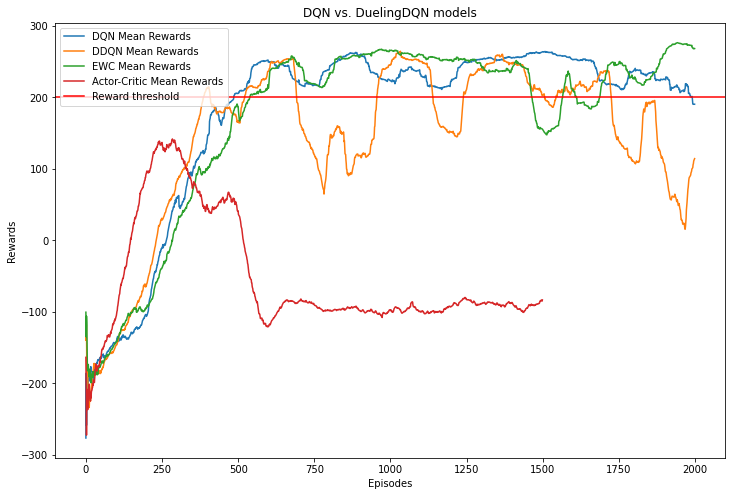

In [28]:
# Plot DQN vs DDQN vs EWC vs Actor-Critic mean rewards
plt.figure(figsize=(12,8))
plt.plot(resultsDQN, label='DQN Mean Rewards')
plt.plot(resultsDDQN, label='DDQN Mean Rewards')
plt.plot(resultsEWC, label='EWC Mean Rewards')
plt.plot(resultsAC, label='Actor-Critic Mean Rewards')
plt.axhline(200, color='r', label="Reward threshold")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('DQN vs. DuelingDQN models')
plt.legend(loc="upper left")
plt.show()